# Benchmark FUSE against STEP

In [1]:
using Revise
using FUSE
using Plots; gr();
using Printf
FUSE.logging(Logging.Info);

## Initialize with GASC v1 JSON file (FPPv1.0_aspectRatio3.5_PBpR35.json)

In [2]:
ini, act = FUSE.case_parameters(:FPP; version=:v1, init_from=:scalars);

### Modify select parameters to better match STEP solution

In [3]:
ini.equilibrium.R0 = 4.824
ini.equilibrium.ϵ = 1/3.5
ini.equilibrium.κ = 2.19
ini.equilibrium.δ = 0.7
ini.equilibrium.ζ = 0.0

ini.equilibrium.ip = 8.0e6
#ini.material.wall = "Tungsten"
#ini.material.shield = "Steel, Stainless 316"
ini.core_profiles.T_shaping = 2.0
ini.core_profiles.n_shaping = 2.0
ini.core_profiles.greenwald_fraction = 1.2
ini.core_profiles.greenwald_fraction_ped = missing
ini.core_profiles.ne_ped = 1.0e20
ini.core_profiles.impurity = :Kr
ini.core_profiles.zeff = 2.0
ini.core_profiles.T_ratio = 1.23

ini.pf_active.n_coils_outside = 8
ini.ec_launchers.power_launched[1] = 74e6
ini.nbi.power_launched = 0.1e6
ini.nbi.beam_energy = 10e3

#ini.build.n_first_wall_conformal_layers = 1

ini.equilibrium.boundary_from = :scalars
ini.equilibrium.xpoints_number = 2



#display(ini)

2

### Modify select actor settings to better match GASC solution

In [4]:
act.ActorEquilibrium.model = :CHEASE
act.ActorEquilibrium.symmetrize = true
act.ActorCHEASE.free_boundary = true
act.ActorCXbuild.rebuild_wall = true

act.ActorTauenn.T_shaping = 2.0
act.ActorTauenn.confinement_factor = 0.95

act.ActorCosting.model = :Sheffield

#display(act)

:Sheffield

### Run FUSE.init

In [5]:
dd = IMAS.dd()
@time FUSE.init(dd, ini, act; do_plot=false);


153.032895 seconds (411.75 M allocations: 20.805 GiB, 6.53% gc time, 81.19% compilation time)


GEOMETRY                       EQUILIBRIUM                    TEMPERATURES                   DENSITIES                      
───────────────────────────    ───────────────────────────    ───────────────────────────    ───────────────────────────    
R0 → 4.82 [m]                  B0 → 4.71 [T]                  Te0 → 12.4 [keV]               ne0 → 2.01e+20 [m⁻³]           
a → 1.38 [m]                   ip → 8.01 [MA]                 Ti0 → 10.1 [keV]               ne_ped → 1e+20 [m⁻³]           
1/ϵ → 3.5 [m]                  q95 → 4.26                     <Te> → 5.61 [keV]              <ne> → 1.36e+20 [m⁻³]          
κ → 2.19                       βpol → 1.67                    <Ti> → 4.56 [keV]              ne0/<ne> → 1.47                
δ → 0.697                      βtor → 0.037                   Te0/<Te> → 2.21                fGW → 1.19                     
ζ → -0.00796                   βn → 3                         Ti0/<Ti> → 2.21                zeff_ped → 2                   


​


28×9 DataFrame
 Row │ group   details               type      ΔR         R_start   R_end     material      area       volume     
     │ String  String                String    Float64    Float64   Float64   String        Float64    Float64    
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ in                                      1.19804     0.0       1.19804                15.6092      58.7491
   2 │ in                            oh        0.353714    1.19804   1.55176  ReBCO          4.6085      39.8116
   3 │ in                                      0.0696397   1.55176   1.6214                  0.907329     9.04493
   4 │ hfs                           tf        0.310622    1.6214    1.93202  ReBCO         11.4595     116.744
   5 │ hfs                                     0.0696397   1.93202   2.00166                29.9566    1614.42
   6 │ hfs     low temp              shield    0.428631    2.00166   2.43029 

​


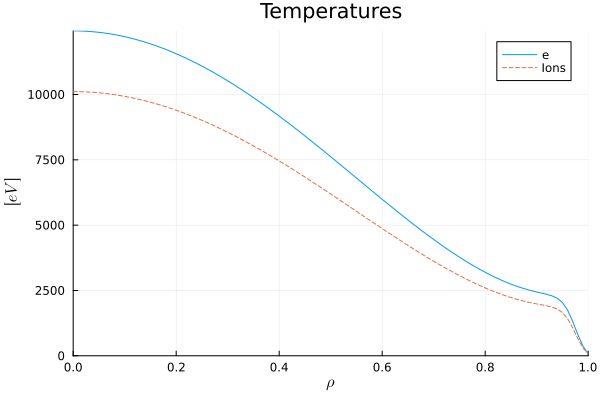

​


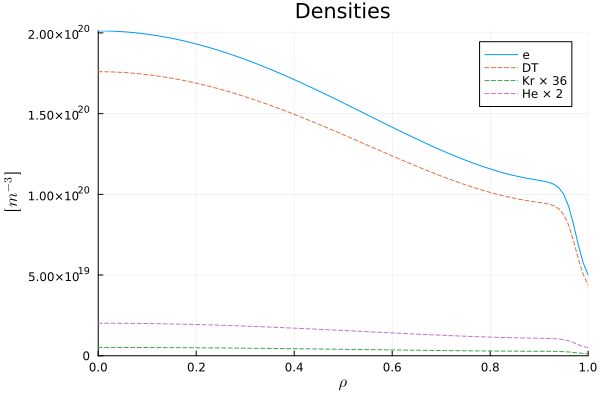

​


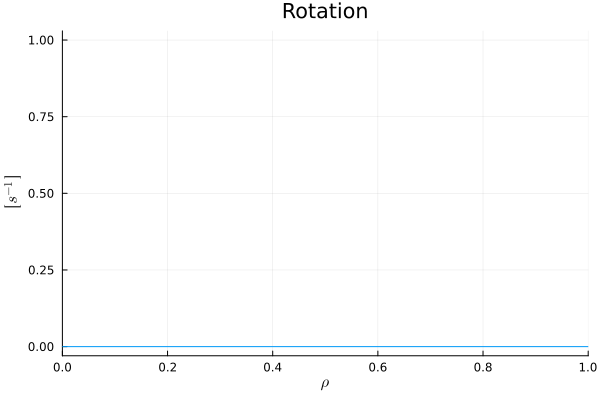

​


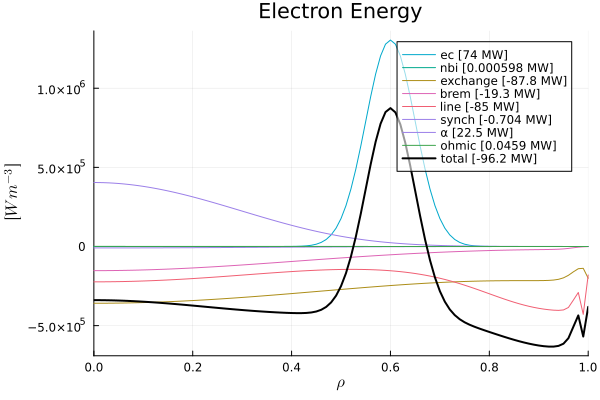

​


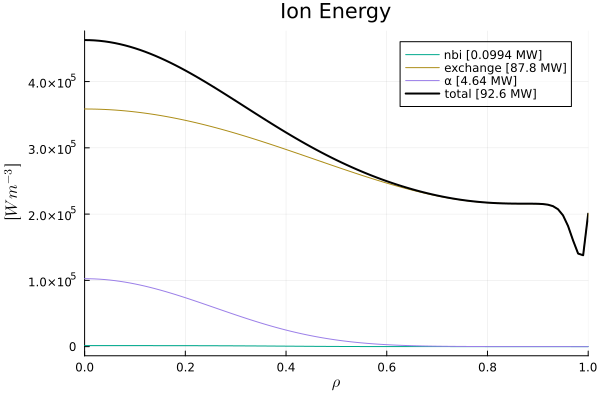

​


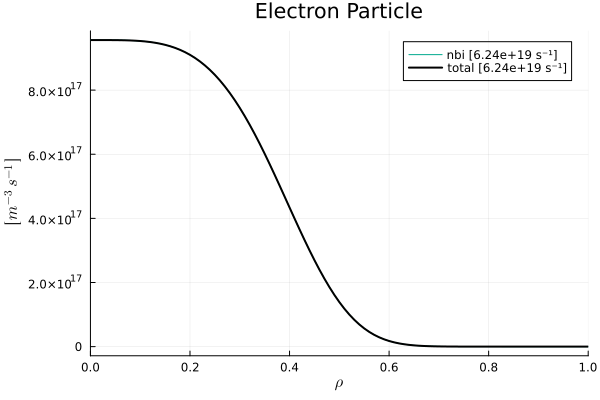

​


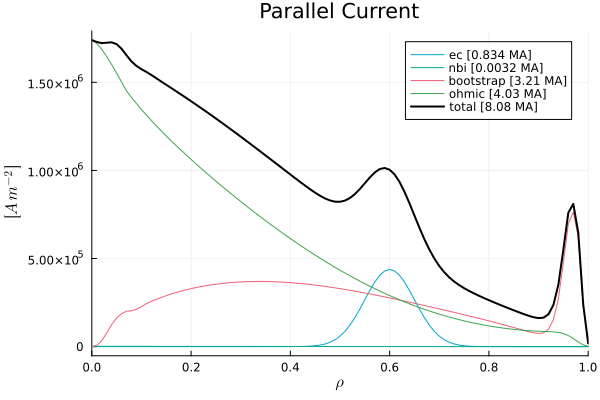

In [6]:
FUSE.digest(dd)

## Run EquilibriumTransport with Tauenn DS03 transport actor 

In [7]:
dd_tauenn = deepcopy(dd)

act.ActorTauenn.temp_pedestal_ratio = 1/1.23
@time FUSE.ActorEquilibriumTransport(dd_tauenn, act);

149.676907 seconds (66.14 M allocations: 3.787 GiB, 0.94% gc time, 11.89% compilation time)


GEOMETRY                       EQUILIBRIUM                    TEMPERATURES                   DENSITIES                      
───────────────────────────    ───────────────────────────    ───────────────────────────    ───────────────────────────    
R0 → 4.82 [m]                  B0 → 4.71 [T]                  Te0 → 25.6 [keV]               ne0 → 2.01e+20 [m⁻³]           
a → 1.38 [m]                   ip → 7.87 [MA]                 Ti0 → 20.8 [keV]               ne_ped → 1e+20 [m⁻³]           
1/ϵ → 3.5 [m]                  q95 → 5.61                     <Te> → 10.3 [keV]              <ne> → 1.36e+20 [m⁻³]          
κ → 2.19                       βpol → 2.74                    <Ti> → 8.37 [keV]              ne0/<ne> → 1.47                
δ → 0.697                      βtor → 0.0547                  Te0/<Te> → 2.48                fGW → 1.21                     
ζ → -0.00796                   βn → 4.55                      Ti0/<Ti> → 2.48                zeff_ped → 2                   


​


28×9 DataFrame
 Row │ group   details               type      ΔR         R_start   R_end     material      area       volume     
     │ String  String                String    Float64    Float64   Float64   String        Float64    Float64    
─────┼────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ in                                      1.19804     0.0       1.19804                15.6092      58.7491
   2 │ in                            oh        0.353714    1.19804   1.55176  ReBCO          4.6085      39.8116
   3 │ in                                      0.0696397   1.55176   1.6214                  0.907329     9.04493
   4 │ hfs                           tf        0.310622    1.6214    1.93202  ReBCO         11.4595     116.744
   5 │ hfs                                     0.0696397   1.93202   2.00166                29.9566    1614.42
   6 │ hfs     low temp              shield    0.428631    2.00166   2.43029 

​


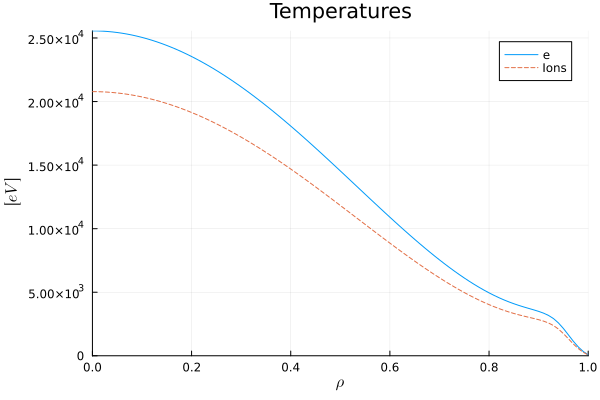

​


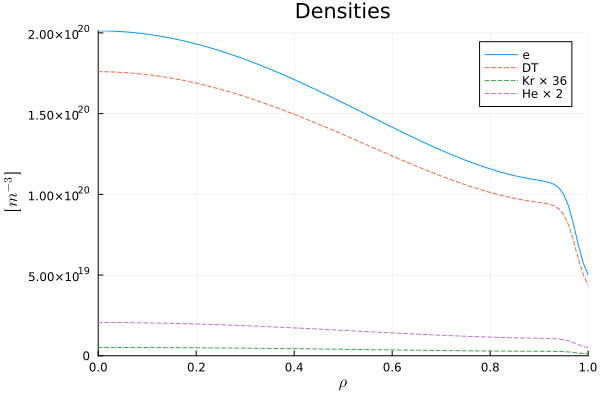

​


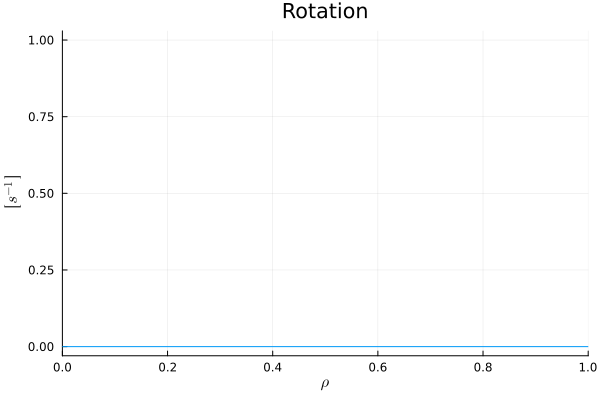

​


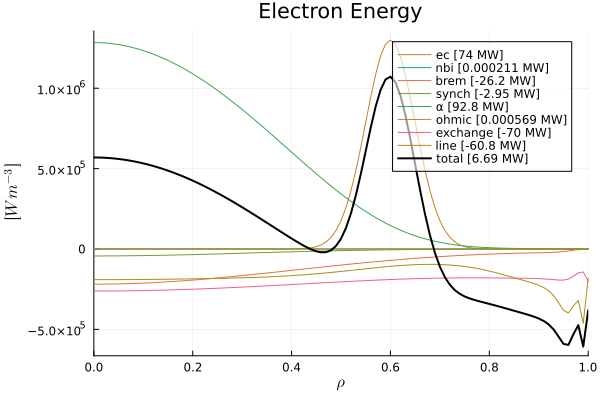

​


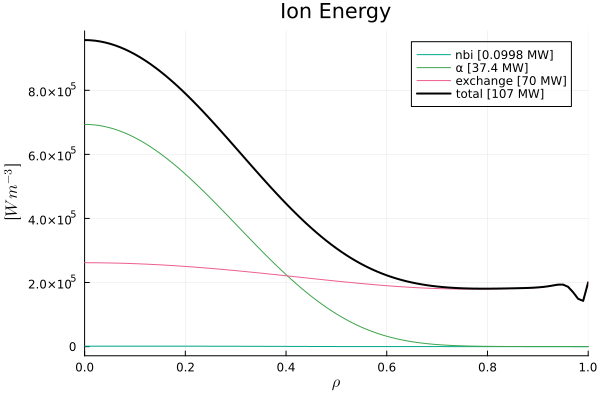

​


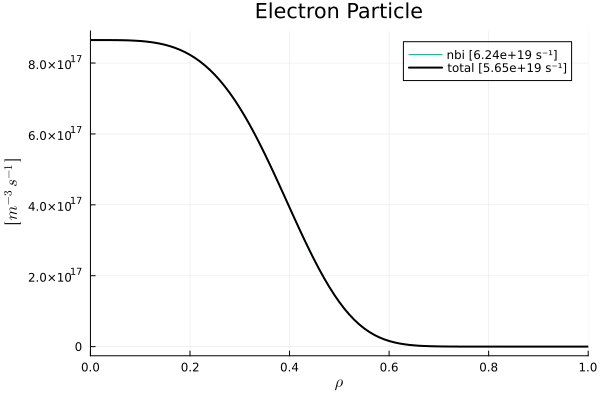

​


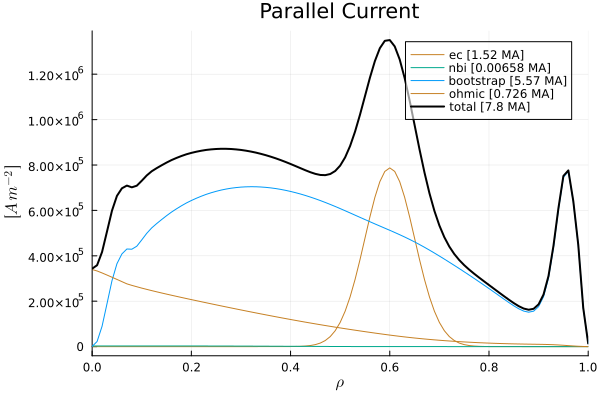

In [8]:
FUSE.digest(dd_tauenn)

## Run EquilibriumTransport with flux-matcher tglfnn actor

In [9]:
act.ActorTauenn.transport_model = :tglfnn
act.ActorTauenn.do_plot = false
act.ActorTauenn.verbose = false

act.ActorCoreTransport.model = :FluxMatcher
act.ActorFluxMatcher.evolve_densities = Dict(:electrons=>:flux_match,:DT=>:quasi_neutrality,:He=>:match_ne_scale,:He_fast=>:constant,:Kr=>:match_ne_scale)
act.ActorFluxMatcher.evolve_rotation = :fixed
act.ActorFluxMatcher.verbose = true
act.ActorFluxMatcher.do_plot = true
act.ActorFluxMatcher.step_size = 0.5

act.ActorTGLF.sat_rule = :sat0
act.ActorTGLF.electromagnetic = false
act.ActorTGLF.rho_transport = (0.2:0.1:0.9)
act.ActorFluxMatcher.rho_transport = (0.2:0.1:0.9)

display(act.ActorFluxMatcher.evolve_densities)

display(act.ActorEquilibriumTransport)
display(act.ActorCoreTransport)
display(act.ActorTauenn)
display(act.ActorTGLF)
display(act.ActorFluxMatcher)

Dict{Symbol, Symbol} with 5 entries:
  :DT        => :quasi_neutrality
  :He_fast   => :constant
  :Kr        => :match_ne_scale
  :He        => :match_ne_scale
  :electrons => :flux_match

ActorEquilibriumTransport{Float64}
├─ do_plot ➡ false Plot
├─ max_iter ➡ 5 max number of transport-equilibrium iterations
└─ convergence_error ➡ 0.01 Convergence error threshold (relative change in current and pressure profiles)


ActorCoreTransport{Float64}
└─ model ➡ :FluxMatcher Transport actor to run [:Tauenn, :FluxMatcher]


ActorTauenn{Float64}
├─ error ➡ 0.01 Target convergence error
├─ eped_factor ➡ 1.0 Scaling parameter for EPED-NN prediction
├─ rho_fluxmatch ➡ 0.6 Radial location where flux-macthing is done
├─ T_shaping ➡ 2.0 Shaping coefficient for the temperature profile
├─ temp_pedestal_ratio ➡ 0.8130081300813008 Ion to electron temperature ratio in the pedestal
├─ transport_model ➡ :tglfnn Transport model [:tglfnn, :tglf, :h98y2, :ds03]
├─ warn_nn_train_bounds ➡ false Warn if EPED-NN / TGLF-NN training bounds are exceeded
├─ eped_only_powerlaw ➡ false EPED-NN uses power-law pedestal fit (without NN correction)
├─ update_pedestal ➡ true update pedestal with eped_nn inside TAUENN
├─ confinement_factor ➡ 0.95 Confinement multiplier
├─ do_plot ➡ false Plot
└─ verbose ➡ false Verbose


ActorTGLF{Float64}
├─ nn ➡ true Use TGLF-NN
├─ sat_rule ➡ :sat0 Saturation rule [:sat0, :sat0quench, :sat1, :sat1geo, :sat2]
├─ electromagnetic ➡ false Electromagnetic or electrostatic
├─ rho_transport ➡ 0.2:0.1:0.9 rho_tor_norm values to compute tglf fluxes on
└─ warn_nn_train_bounds ➡ false Raise warnings if querying cases that are certainly outside of the training range


ActorFluxMatcher{Float64}
├─ evolve_Ti ➡ :flux_match Evolve ion temperature  [:flux_match, :fixed]
├─ evolve_Te ➡ :flux_match Evolve electron temperature [:flux_match, :fixed]
├─ evolve_densities ➡ Dict{Symbol, Symbol}(
│                     :DT => :quasi_neutrality
│                     :He_fast => :constant
│                     :Kr => :match_ne_scale
│                     :He => :match_ne_scale
│                     :electrons => :flux_match) Dict to specify which ion species are evolved, kept constant, or used to
│  enforce quasi neutarlity
├─ evolve_rotation ➡ :fixed Evolve the electron temperature [:flux_match, :fixed]
├─ rho_transport ➡ 0.2:0.1:0.9 Rho transport grid
├─ evolve_pedestal ➡ true Evolve the pedestal inside the transport solver
├─ max_iterations ➡ 200 Maximum optimizer iterations
├─ optimizer_algorithm ➡ :anderson Optimizing algorithm used for the flux matching [:anderson, :jacobian_based]
├─ step_size ➡ 0.5 Step size for each algorithm iteration (note this has a dif

### Add function for pellet fueling

In [10]:
function add_pellet_source(dd,electrons_particles,rho_0,width)
    eqt = dd.equilibrium.time_slice[]
    cp1d = dd.core_profiles.profiles_1d[]
    cs = dd.core_sources
    isource = resize!(cs.source, "identifier.name" => "arb pellet")
    rho_cp = cp1d.grid.rho_tor_norm
    volume_cp = IMAS.interp1d(eqt.profiles_1d.rho_tor_norm, eqt.profiles_1d.volume).(rho_cp)
    area_cp = IMAS.interp1d(eqt.profiles_1d.rho_tor_norm, eqt.profiles_1d.area).(rho_cp)
    power_launched = 0.0
    gauss_order=1.0

    return FUSE.gaussian_source(
        isource,
        "arb pellet",
        901,
        rho_cp,
        volume_cp,
        area_cp,
        power_launched,
        ones(length(rho_cp)),
        rho_0,
        width,
        gauss_order;
        electrons_particles,
        momentum_tor=missing,
        j_parallel=missing
    )
end

add_pellet_source (generic function with 1 method)